In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
testImgs = None
testLabels = None
y_preds = None
trainImgs = None
trainLabels = None
valImgs = None
valLabels = None

In [5]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
d = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  d + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs   = getData(dataPath, trainImgsFile)
trainLabels = getData(dataPath, trainLabelsFile)

valImgs    = getData(dataPath, valImgsFile)
valLabels  = getData(dataPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)


Got train and validation data
(1000, 480, 480, 1) (251, 480, 480, 1)
(1000, 480, 480, 1) (251, 480, 480, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.PSPNet('inceptionresnetv2', input_shape=(480, 480, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [35]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    #y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [14]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [9]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [15]:
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 116s 116ms/sample - loss: 0.1342 - accuracy: 0.9647 - updated_mean_io_u_1: 0.1503 - val_loss: 0.2347 - val_accuracy: 0.9632 - val_updated_mean_io_u_1: 0.0876
Epoch 2/30
1000/1000 [==============================] - 105s 105ms/sample - loss: 0.0425 - accuracy: 0.9862 - updated_mean_io_u_1: 0.3237 - val_loss: 0.1386 - val_accuracy: 0.9760 - val_updated_mean_io_u_1: 0.0907
Epoch 3/30
1000/1000 [==============================] - 106s 106ms/sample - loss: 0.0341 - accuracy: 0.9883 - updated_mean_io_u_1: 0.4530 - val_loss: 0.1020 - val_accuracy: 0.9778 - val_updated_mean_io_u_1: 0.1153
Epoch 4/30
1000/1000 [==============================] - 105s 105ms/sample - loss: 0.0280 - accuracy: 0.9899 - updated_mean_io_u_1: 0.5330 - val_loss: 0.0722 - val_accuracy: 0.9823 - val_updated_mean_io_u_1: 0.1668
Epoch 5/30
1000/1000 [==============================] - 105s 105ms/sample - loss: 0.0249 - accura

dict_keys(['loss', 'accuracy', 'updated_mean_io_u_1', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u_1'])


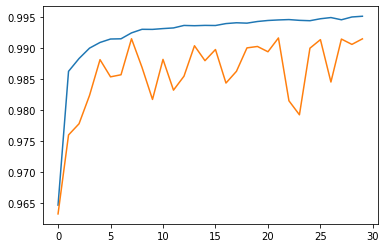

In [16]:
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

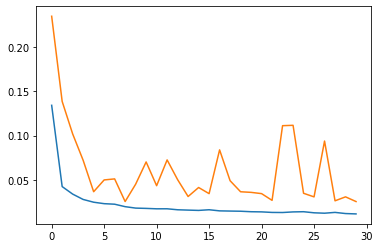

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

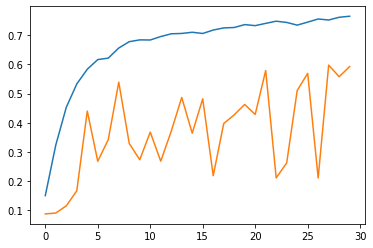

In [19]:
plt.plot(history.history['updated_mean_io_u_1'])
plt.plot(history.history['val_updated_mean_io_u_1'])

In [22]:
# get the testdata
testImgs   = getData(dataPath, testImgsFile)
testLabels = getData(dataPath, testLabelsFile)
print(testImgs.shape, testLabels.shape)

(617, 480, 480, 1) (617, 480, 480, 1)


In [28]:
trainImgs = None
trainLabels = None
valImgs = None
valLabels = None

In [ ]:
model.evaluate(testImgs, testLabels)

In [25]:
# save the model weights
weightFileName = "PSPInceptionResNetV2_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/PSPNET'
model.save_weights(weightPath + "/" + weightFileName)


In [ ]:
model.load_weights(weightPath + "/" + weightFileName)
#model.evaluate(testImgs, testLabels)

In [ ]:
modelFileName = "PSPInceptionResNetV2_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/PSPNET'
model.save(modelPath + "/" + modelFileName)

In [29]:
# Check the GPU configuration
!nvidia-smi

Fri May 28 16:59:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    59W / 149W |  11043MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
y_preds = tf.argmax(model.predict(testImgs),-1)
#y_preds = (y_preds >= 0.5).astype(np.uint8)

In [33]:
testImgs = None

In [36]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

Overall mean IOU is : 0.5848612785339355


In [37]:
numClasses = 12
classIOU = []
for i in range(numClasses):
  rowSum = np.sum(values[i,:])
  colSum = np.sum(values[:,i])
  denom = rowSum + colSum - values[i,i]
  iou = values[i,i]/denom
  classIOU.append(iou)

print(classIOU)
perClassIoU = np.array(classIOU)
print(np.mean(perClassIoU))

[0.9908648839627064, 0.6154214740558603, 0.18940331765288437, 0.4719996667742708, 0.6153293821270795, 0.4361176015252075, 0.6185575578609772, 0.6239531186979524, 0.5474585950885208, 0.8193877254956007, 0.3710969429458885, 0.7187451678733885]
0.5848612861716946


In [ ]:
yPreds = tf.argmax(ypreds, axis=-1)
yPreds = yPreds.numpy()

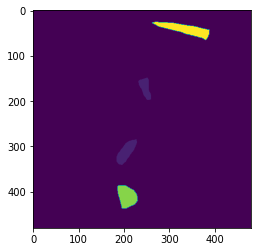

[ 0  1  9 11]


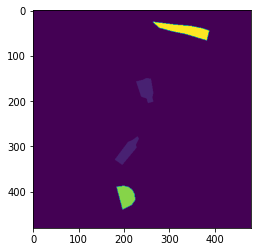

[ 0.  1.  9. 11.]


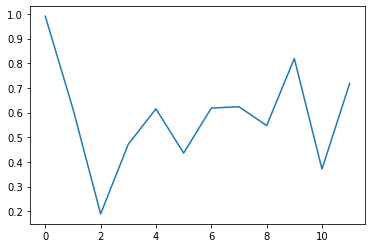

In [38]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(y_preds[i])
plt.show()

print(np.unique(y_preds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()